## Make hi-res convolutions go faster

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from theano import tensor as tnsr
from theano import function, scan
from time import time
from scipy.signal import convolve2d as conv2d
from hrf_fitting.src.features import make_gaussian, construct_placement_grid
from glob import glob
from scipy.io import loadmat
from hrf_fitting.src.feature_weighted_rf_models import apply_rf_to_feature_maps, bigmult, compute_grad,sq_diff_func
from hrf_fitting.src.features import make_complex_gabor as gaborme
from PIL import Image
from scipy.stats import pearsonr
from scipy.misc import imresize



Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GTX 760


### Step 1: construct feature maps

In [2]:
Df, Do = 8, 8  #Df = sp. freq. divisions, Do = orientations
D = Df*Do + 1  # +1 for a bias dimension

#### load crcns stimuli

In [3]:
stim_location = '/media/tnaselar/Data/crcns_datasets/vim-1/Stimuli.mat'
crcns_stim_dict = loadmat(stim_location)

In [4]:
##need 'stimVal' and 'stimTrn'
print crcns_stim_dict['stimVal'].shape
print crcns_stim_dict['stimTrn'].shape

(120, 128, 128)
(1750, 128, 128)


In [5]:
##remember stim params
Ttrn = crcns_stim_dict['stimTrn'].shape[0]
Tval = crcns_stim_dict['stimVal'].shape[0]
T = Ttrn+Tval
native_stim_size = crcns_stim_dict['stimTrn'].shape[1]
n_image_channels = 1 ##could be 3 for color images.
stim_size = 512


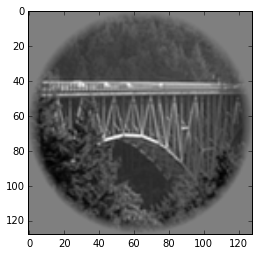

In [6]:
plt.imshow(crcns_stim_dict['stimVal'][0,:,:],cmap='gray')

#### construct gabor wavelet stack

In [137]:
###STIMULUS RESOLUTION SHOULD VARY ACROSS SP. FREQs SO THAT EACH SP. FREQ HAS SAME NUMBER OF PIXELS PER CYCLE

##parameters for designing gabor feature maps
##specify frequencies in cycles_per_pixel, use to determine size of prf.
##should probably specify in cycles per deg.

##------Up to you 

##determined by stimulus presentation during experiment (e.g., viewing distance, resolution)
native_pix_per_deg = 25    ##at native resolution, i.e., the resolution during the experiment
deg_per_stimulus = 20 ##given the native resolution and viewing distance

##you decide how many cyc/deg you want
cycles_per_deg = .2*np.logspace(0,1.795809999999,num=Df)#.05*np.logspace(0,1.9199999999999999999,num=Df)##.05*np.logspace(0,2.3979,num=Df)

##you decide how many pixels per cycle you want.
##Nyquist = 2 is fine for vert. or horz. orientations, but too jaggy (probably) for obliques.
##but if too high, usually will require stimuli with larger than native resolution.
##so there is a tradeoff between frequency and oriention implied here.
pix_per_cycle = 2.

##here is where you determine the radius of each gabor filter. we specify how many cycles we expect
##per radius (= one stdev of gaussian envelope)
cycles_per_radius = 1.

##you might also want to insist that the *picture of* the gabor filter be big enough to house a certain number of radii.
diams_per_filter = 2. ##determines how big the picture of the gabor will be.


##------Inferred from your choices
##radius of gaussian envelope of gabor filters in deg.
envelope_radius = cycles_per_radius * (1./cycles_per_deg)

##given the radius per filter, this is how many degrees the filter diameter should be
deg_per_filter = 2*envelope_radius * diams_per_filter


#given min. pix/cyc, here's the minimum pixels per stimulus you can live with.
min_pixels_per_stimulus = pix_per_cycle * cycles_per_deg * deg_per_stimulus

##given deg/filter and min pix/cyc, this is how big the filter should be (in pixels)
pix_per_filter = deg_per_filter * pix_per_cycle * cycles_per_deg


metrics = {'cycles per deg.': cycles_per_deg,      ##len = Df
           'min pix per stimulus' : min_pixels_per_stimulus,
           'radius of Gauss. envelope (deg)': envelope_radius,
            'filter diameter (deg.)': deg_per_filter,
          'pix_per_filter': pix_per_filter}
 
fm = pd.DataFrame(metrics)
fm

,cycles per deg.,filter diameter (deg.),min pix per stimulus,pix_per_filter,radius of Gauss. envelope (deg)
0,0.200000,20.000000,8.000000,8,5.000000
1,0.361056,11.078621,14.442231,8,2.769655
2,0.651806,6.136792,26.072253,8,1.534198
3,1.176692,3.399360,47.067686,8,0.849840
4,2.124257,1.883011,84.970296,8,0.470753
5,3.834877,1.043058,153.395075,8,0.260765
6,6.923022,0.577782,276.920879,8,0.144446
7,12.497985,0.320052,499.919396,8,0.080013


In [138]:
oris = np.linspace(0, 2*np.pi, num=Do, endpoint=False)

#### generate feature maps

In [139]:
##--make a theano function for this
stim_tnsr = tnsr.tensor4('stim_tnsr')  ##T x n_image_channels x stim_size x stim_size
real_filter_stack_tnsr = tnsr.tensor4('real_feature_map_tnsr') ##D x n_image_channels x stim_size x stim_size. complex
imag_filter_stack_tnsr = tnsr.tensor4('imag_feature_map_tnsr') ##D x n_image_channels x stim_size x stim_size. complex
filter_stack_tnsr_shape = (1, n_image_channels,stim_size,stim_size)
real_feature_map_tnsr = tnsr.nnet.conv2d(stim_tnsr,
                                 real_filter_stack_tnsr,
                                 image_shape = (1,n_image_channels,stim_size,stim_size),
#                                  filter_shape = filter_stack_tnsr_shape,
                                 border_mode = 'full')  ##produces T x D x stim_size x stim_size maps
imag_feature_map_tnsr = tnsr.nnet.conv2d(stim_tnsr,
                                 imag_filter_stack_tnsr,
                                 image_shape = (1,n_image_channels,stim_size,stim_size),
#                                  filter_shape = filter_stack_tnsr_shape,
                                 border_mode = 'full')  ##produces T x D x stim_size x stim_size maps

##for filtering with complex gabors, we need an operation for squaring/summing real/imag parts

abs_value = tnsr.sqrt(tnsr.sqr(real_feature_map_tnsr) + tnsr.sqr(imag_feature_map_tnsr))
##functionize feature mapping
make_feature_maps = function(inputs = [stim_tnsr,real_filter_stack_tnsr,imag_filter_stack_tnsr],
                             outputs = abs_value)

In [ ]:
##create filter stack, but separate real/imag parts because theano doesn't like complex numbers
##here we leave Dth filter at zero because later we will add a "bias" feature of all 1's.
filter_channels = 2
filter_dictionary = {}
f_counter = 0
feature_map_params = []
for df in range(Df):
    for do in range(Do):
        ori = oris[do]
        center = (0,0)
        freq = fm.loc[df,'cycles per stimulus']
        fwhm = fm.loc[df,'fwhm (pix)']
        n_pix = int(fm.loc[df,'n_pix'])
        feature_map_params.append( (ori,freq,fwhm,n_pix) )
        tmp_filter = gaborme(freq,ori,center,fwhm,n_pix)
        filter_dictionary[f_counter] = [np.real(tmp_filter).astype('float32'), np.imag(tmp_filter).astype('float32')]
        f_counter += 1

In [ ]:
##show real part of some filters
plt.figure(figsize=(20,20))
n_examples = 4
examps = np.linspace(0,D,endpoint=False,num=n_examples).astype('int')
for i,n in enumerate(examps):
    plt.subplot(1,n_examples,i+1)
    sz = filter_dictionary[n][0].shape[0]
    plt.imshow(np.pad(filter_dictionary[n][0],(np.round((stim_size-sz)/2.).astype('int'),),mode='constant'),cmap='gray')
print len(filter_dictionary.keys())

In [ ]:
feature_map_params = pd.DataFrame(data=feature_map_params,columns=['ori','freq','fwhm','n_pix'])

In [ ]:
feature_map_params.head()

In [ ]:

stimulus = imresize(crcns_stim_dict['stimVal'][0],(stim_size,stim_size)).astype('float32')
plt.imshow(stimulus)

In [ ]:
feature_maps = np.zeros((D,stim_size,stim_size)).astype('float32')
for d in range(Df*Do):
    start = time()
    this_stim = stimulus[np.newaxis,np.newaxis,:,:]
    tmp_feature_map = make_feature_maps(this_stim,
                                        filter_dictionary[d][0][np.newaxis,np.newaxis,:,:],
                                        filter_dictionary[d][1][np.newaxis,np.newaxis,:,:])
    
    ##crop because convolution
    new_size = tmp_feature_map.shape[2]
    crop_start = np.round((new_size-stim_size)/2.).astype('int')
    crop_stop = crop_start+stim_size
    feature_maps[d,:,:] = tmp_feature_map[:, :, crop_start:crop_stop, crop_start:crop_stop]
    print 'feature %d took %0.3f' %(d,time()-start)
print feature_maps.shape

In [ ]:
filter_dictionary[d][0].shape